In [14]:
%matplotlib inline

import scipy
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import sensie

## MNIST - sensitivity to input orientation

In [15]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train[:, :, :, np.newaxis]
X_test = X_test[:, :, :, np.newaxis]



In [16]:
def make_model_mnist(): 
    input_shape = (28, 28, 1)
    model = keras.models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [17]:
model = make_model_mnist()
batch_size = 128
num_epoch = 10

In [18]:
savemodel = False # Handy to repeat the experiment
if savemodel and os.path.exists("/tmp/mnist.h5"):
    model.load_weights("/tmp/mnist.h5")
else:
    model_log = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=num_epoch,
              verbose=1,
              validation_data=(X_test, y_test))

    if savemodel:
        model.save("/tmp/mnist.h5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.2432 - accuracy: 0.9251 - val_loss: 0.0531 - val_accuracy: 0.9814
Epoch 2/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0874 - accuracy: 0.9740 - val_loss: 0.0393 - val_accuracy: 0.9872
Epoch 3/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0649 - accuracy: 0.9805 - val_loss: 0.0328 - val_accuracy: 0.9891
Epoch 4/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0547 - accuracy: 0.9831 - val_loss: 0.0346 - val_accuracy: 0.9882
Epoch 5/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.0464 - accuracy: 0.9854 - val_loss: 0.0308 - val_accuracy: 0.9907
Epoch 6/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0427 - accuracy: 0.9866 - val_loss: 0.0321 - val_accuracy: 0.9904
Epoch 7/10
60000/60000 [==============================] 

In [19]:
# Should be 99% accurate
model.evaluate(X_test, y_test, verbose=2)

10000/10000 - 1s - loss: 0.0326 - accuracy: 0.9914


[0.03264011251021548, 0.9914]

In [20]:
# Define a function to rotate a digit example

def rotate(X, angle):
    rotated = scipy.ndimage.rotate(X, angle, axes=(1,2))
    w = int(rotated.shape[1]/2)
    return rotated[:, w-14:w+14, w-14:w+14, :]
    

Now, create a probe object to wrap the model, then pass it the rotate function to test the sensitivity to rotation using the test set; we'll test rotation from 0 to 180 degrees.

[########################################] 100% (20/20)    180.00  

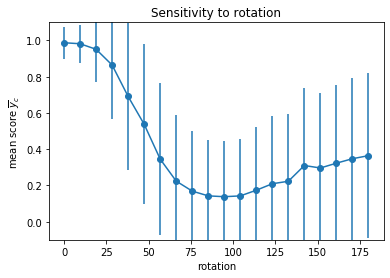

In [21]:
mnist_probe = sensie.Probe(model=model)
pfunc = rotate
rot_test = mnist_probe.predict_and_measure_perturbed(X_test, y_test, pfunc, p_min=0, p_max=180, steps=20, 
                              label='rotation', plot=True, ci=False)

Yes, this looks like a significant effect. 

This could be viewed as a weakness of the model. Let's retrain with rotated
examples and see how things change.

In [22]:
X_train_rot = np.empty_like(X_train)
X_test_rot = np.empty_like(X_test)
for i in range(X_train.shape[0]):
    angle = np.random.random()*180
    X_train_rot[i:i+1] = rotate(X_train[i:i+1], angle)
    if i < X_test.shape[0]:
        X_test_rot[i:i+1] = rotate(X_test[i:i+1], angle)


In [23]:
model_log = model.fit(X_train_rot, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(X_test_rot, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.4919 - accuracy: 0.8563 - val_loss: 0.1367 - val_accuracy: 0.9573
Epoch 2/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.2173 - accuracy: 0.9337 - val_loss: 0.1056 - val_accuracy: 0.9671
Epoch 3/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.1735 - accuracy: 0.9463 - val_loss: 0.0956 - val_accuracy: 0.9709
Epoch 4/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1433 - accuracy: 0.9558 - val_loss: 0.0910 - val_accuracy: 0.9719
Epoch 5/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.1260 - accuracy: 0.9598 - val_loss: 0.0853 - val_accuracy: 0.9743
Epoch 6/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.1127 - accuracy: 0.9641 - val_loss: 0.0825 - val_accuracy: 0.9739
Epoch 7/10
60000/60000 [==============================] 

[########################################] 100% (10/10)    180.00  

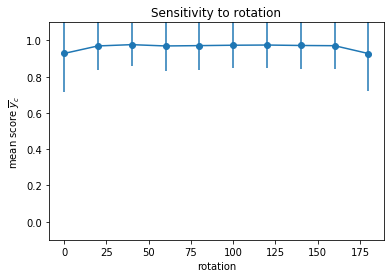

In [24]:
rot_test = mnist_probe.predict_and_measure_perturbed(X_test, y_test, pfunc, p_min=0, p_max=180, steps=10, 
                              label='rotation', plot=True)

That looks better!